In [6]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
from IPython.display import Audio, display
import numpy as np

import os
# This is to force CPU evaluation since we probably train on a bigger GPU than I have
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

#import time
import cmath

import keras
#import keras.layers as layers
#from keras import backend as K
from keras.utils import plot_model
from keras import regularizers
from keras import layers

import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# Constants and settings
WINDOW_SIZE = 35  # Has to be odd
TARGET_COL = WINDOW_SIZE//2

DTYPE = 'float32'

# cqt related
FFT_BINS = 768 # function of items below
HOP_LENGTH = 256

# stft values
N_FFT = 1024 # 512 recommended for speech, music typically 2048

# cqt values
BINS_PER_OCTAVE = 12 * 8
FMIN = librosa.note_to_hz('C1')
OCTAVES = 8

In [8]:
# Idea here is that we operate on magnitude, and will just use phase from the original noisy sample

#def combine_target(t):
#    return (t[0:t.shape[0]//2] + 1j * t[t.shape[0]//2:]).reshape(1,(t.shape[0]//2))

def rebuild_fft(output, original_fft):
    vphase = np.vectorize(cmath.phase)
    o_phase = vphase(original_fft)
    mag = output.T
    vrect = np.vectorize(cmath.rect)
    return vrect(mag, o_phase)
    
# build up as (bins, samples) then transpose to model view of (samples, bins)
#def targets_to_fft(targets):
#    fft = np.empty((targets.shape[0],targets.shape[1]//2), dtype='complex64')
#    for i in range(0, targets.shape[0]):
#        fft[i] = combine_target(targets[i])
#    return fft.T   # transpose

def get_ft(wav):
    c = librosa.cqt(wav, hop_length=HOP_LENGTH, fmin=FMIN, n_bins=OCTAVES*BINS_PER_OCTAVE, bins_per_octave=BINS_PER_OCTAVE)
    #c = librosa.stft(wav, hop_length=HOP_LENGTH, n_fft=N_FFT)
    return c

def inv_ft(ft):
    return librosa.icqt(ft, hop_length=HOP_LENGTH, bins_per_octave=BINS_PER_OCTAVE)
    #return librosa.istft(ft, hop_length=HOP_LENGTH)
    
# Sample output is (samples, bins) all converted to magnitude
def get_samples(file):
    wav, rate = librosa.core.load(file)
    samples = abs(get_ft(wav).T) # organized as bins, frames so we need to transpose them to frames, bins
    return samples

# Only need this for testing at this point?  Could still make it a 'top' type shared function
def clip_frames(file):
    samples = get_samples(file)
    frames = np.empty((samples.shape[0], WINDOW_SIZE, FFT_BINS, 1))
    half_win = WINDOW_SIZE//2
    padded_samples = np.concatenate([np.zeros((half_win, FFT_BINS)), samples, np.zeros((half_win, FFT_BINS))])
    for i in range(0, samples.shape[0]-1):
        frames[i,:,:,0] = padded_samples[i:i+WINDOW_SIZE,:]
    return frames


def display_fft(ft):
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(ft), ref=np.max), y_axis='cqt_hz', x_axis='time')

def draw(wav):
    fft = get_ft(wav)
    display_fft(fft)
    return fft

In [9]:
# some test data to hack around with
test_file = "Assets\\DataShareArchive\\Test\\Clean\\p232_010.wav"
wav, rate = librosa.core.load(test_file)
ft = get_ft(wav)

(768, 239)


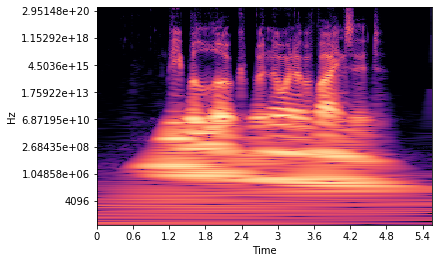

In [10]:
# Round trip test with no NN evaluation to test pipeline

test_file = "Assets\\DataShareArchive\\Test\\Clean\\p232_010.wav"
wav, rate = librosa.core.load(test_file)

ft = get_ft(wav)
samples = get_samples(test_file)

rt_ft = rebuild_fft(samples, ft)

rt_wav = inv_ft(rt_ft)
print(rt_ft.shape)

display_fft(rt_ft)
Audio(rt_wav,rate=22050)

In [ ]:
model = keras.models.load_model("model_2020-01-16_04-57.h5")

In [ ]:
# Full round trip test
file = "p232_001.wav"

verify_file = "Assets\\DataShareArchive\\Test\\Noisy\\" + file
clean_file = "Assets\\DataShareArchive\\Test\\Clean\\" + file


def clean_clip(model, n_file):
    verify_frames = clip_frames(n_file)
    output_targets = model.predict([verify_frames])
    wav, rate = librosa.core.load(n_file)
    n_fft = get_ft(wav)
    fft = rebuild_fft(output_targets, n_fft)
    return fft, inv_ft(fft)


p_fft, p_wav = clean_clip(model, verify_file)
    
wav, rate = librosa.core.load(clean_file)
c_fft = get_ft(wav)


print("Cleaned clip")

err_fft = c_fft - p_fft
print("Average abs err vs clean = ", np.mean(abs(err_fft)))

display_fft(p_fft)
Audio(p_wav,rate=22050)

In [ ]:
wav, rate = librosa.core.load(verify_file)
n_fft = draw(wav)

err_fft = c_fft - n_fft
print("Average abs err vs clean = ", np.mean(abs(err_fft)))

print("Noisy file")
Audio(wav, rate=rate)

In [ ]:
wav, rate = librosa.core.load(clean_file)
c_fft = draw(wav)

print("Clean sample")
Audio(wav, rate=rate)

In [ ]:
cut_fft = n_fft-p_fft
display_fft(cut_fft)

print("Removed audio")
print("Average cut value = ", np.mean(abs(cut_fft)))

cut_wav = inv_ft(cut_fft)
Audio(cut_wav,rate=22050)
